# Health Claim Analysis



# Task 1 - Cross Domain Classification

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import string
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
!git clone -b master https://github.com/charles9n/bert-sklearn
!cd bert-sklearn; pip install .
from bert_sklearn import BertClassifier

Cloning into 'bert-sklearn'...
remote: Enumerating objects: 259, done.
remote: Total 259 (delta 0), reused 0 (delta 0), pack-reused 259
Receiving objects: 100% (259/259), 516.15 KiB | 3.37 MiB/s, done.
Resolving deltas: 100% (131/131), done.
Processing /content/bert-sklearn
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.2 MB/s eta 0:00:00
  Created wheel for bert-sklearn: filename=bert_sklearn-0.3.1-py3-none-any.whl size=54223 sha256=c6426ac9b96d1c714740a8caf359b157a4f90ce106467e839285889278a8daa2
  Stored in directory: /root/.cache/pip/wheels/29/f7/03/c9d257b287e1a5ef7ee4300cbbcd70cfbb13e8b6759da24477
Successfully built bert-sklearn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
claims_pubmed = pd.read_csv("/content/drive/MyDrive/IST 736 Text Mining/HW3/annotated_pubmed.csv")
claims_pubmed

,sentence,label
0,Levels of cholesterol fractions in patients wi...,0
1,Faster aspart and IAsp were confirmed noninfer...,0
2,Major operative morbidity after minimally inva...,0
3,"The promise of combining risk assessment, comm...",0
4,PPARÎ´ peroxisome proliferator-activated recep...,0
...,...,...
3056,The etiology of anemia appears to be iron-rela...,1
3057,DM is associated with poor outcomes in patient...,1
3058,The BDI is a significant predictor of long-ter...,1
3059,Poor glycemic control among diabetics is a ris...,1


In [ ]:
claims_pubmed['label'].value_counts().sort_index()

0    1356
1     998
2     213
3     494
Name: label, dtype: int64

In [ ]:
news_headlines_data = pd.read_csv("/content/drive/MyDrive/IST 736 Text Mining/HW3/annotated_eureka.csv")
news_headlines_data

,sentId,sentence,label
0,20824800-w-lss012611-0-title,Low socioeconomic status increases depression ...,3
1,20824800-w-lss012611-1-sentence,A recent study confirmed that low socioeconomi...,1
2,20824800-w-lss012611-2-sentence,"Statistically significant differences in race,...",1
3,20825768-nch-nns011711-0-title,New national study finds 11 500 emergency depa...,0
4,20825768-nch-nns011711-1-sentence,Known by many as one of the least favorite win...,1
...,...,...,...
2071,26837813-b-pfa020216-2-sentence,These results do not support a direct (causal)...,1
2072,28637644-uoe-ccp062217-1-sentence,Specialist antenatal clinics for severely obes...,3
2073,25690672-uoc--urd011315-0-title,UCLA researchers develop new tool to predict p...,1
2074,24171920-tes-ltl102813-0-title,Low thyroid levels may signal heightened risk ...,1


In [ ]:
news_headlines_data['label'].value_counts().sort_index()

0    486
1    738
2    284
3    568
Name: label, dtype: int64

## Data cleaning

In [ ]:
claims_pubmed["sentence"] = claims_pubmed["sentence"].apply(lambda x: re.sub(f"[{re.escape(string.punctuation)}]", "", x))

In [ ]:
news_headlines_data["sentence"] = news_headlines_data["sentence"].apply(lambda x: re.sub(f"[{re.escape(string.punctuation)}]", "", x))

## Splitting Both the Datasets into Training and Testing


In [ ]:
X_pubmed = claims_pubmed['sentence'].values
y_pubmed = claims_pubmed['label'].values

X_nhd = news_headlines_data['sentence'].values
y_nhd = news_headlines_data['label'].values

X_pubmed_train, X_pubmed_test, y_pubmed_train, y_pubmed_test = train_test_split(X_pubmed, y_pubmed, test_size=0.2, random_state=0, shuffle = True)
X_nhd_train, X_nhd_test, y_nhd_train, y_nhd_test = train_test_split(X_nhd, y_nhd, test_size=0.2, random_state=0, shuffle = True)

In [ ]:
### Printing shape of the split data
print(X_pubmed_train.shape, y_pubmed_train.shape, X_pubmed_test.shape, y_pubmed_test.shape)
print(X_nhd_train.shape, y_nhd_train.shape, X_nhd_test.shape, y_nhd_test.shape)

(2448,) (2448,) (613,) (613,)
(1660,) (1660,) (416,) (416,)


## Defining Vectorizers

In [ ]:
#  unigram tfidf vectorizer, set minimum document frequency to 5
unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5,stop_words='english')

## Vectorizing Training and Test Data

In [ ]:
## Vectorizing Training and Testing Data
X_pubmed_train_vec = unigram_tfidf_vectorizer.fit_transform(X_pubmed_train)
X_pubmed_test_vec = unigram_tfidf_vectorizer.transform(X_pubmed_test)


#X_nhd_train_vec = unigram_tfidf_vectorizer.fit_transform(X_nhd_train)
#X_nhd_test_vec = unigram_tfidf_vectorizer.transform(X_nhd_test)

print(X_pubmed_train_vec.shape, X_pubmed_test_vec.shape)
#print(X_nhd_train_vec.shape, X_nhd_test_vec.shape)

(2448, 1145) (613, 1145)


## Initializaing the SVM model

In [ ]:
# initialize the LinearSVC model
svm_clf = LinearSVC(C=1)

## Training the SVM model

In [ ]:
svm_clf.fit(X_pubmed_train_vec, y_pubmed_train)

LinearSVC(C=1)

## Model Predictions, Evaluation and Cross Validation

In [ ]:
#making predictions
y_pred = svm_clf.predict(X_pubmed_test_vec)

#confusion matrix
cm = confusion_matrix(y_pubmed_test, y_pred)
print(cm)

#cross validation on 3 folds
cvs = cross_val_score(svm_clf, X_pubmed_train_vec, y_pubmed_train, cv = 3)
print("CV Scores:", cvs)
print()
print('Cross-validation score :',(cvs.mean()))
print('Precision: %.3f' % precision_score(y_pubmed_test, y_pred,average='macro'))
print('Recall: %.3f' % recall_score(y_pubmed_test, y_pred,average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_pubmed_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_pubmed_test, y_pred,average='macro'))

[[245  27   5  24]
 [ 23 149   1  10]
 [ 13   7  12  12]
 [ 22  12   3  48]]
CV Scores: [0.69485294 0.69730392 0.6752451 ]

Cross-validation score : 0.6891339869281046
Precision: 0.664
Recall: 0.616
Accuracy: 0.741
F1 Score: 0.626


## Top 20 Features for each category from SVM

In [ ]:
feature_ranks_0 = sorted(zip(svm_clf.coef_[0], unigram_tfidf_vectorizer.get_feature_names_out()))
no_rel_20 = feature_ranks_0[-20:]
print("-------No Relationship words-------")
for i in range(0, len(no_rel_20)):
    print(no_rel_20[i])
print()

feature_ranks_1 = sorted(zip(svm_clf.coef_[1], unigram_tfidf_vectorizer.get_feature_names_out()))
casual_20 = feature_ranks_1[-20:]
print("-------Direct Casual words-------")
for i in range(0, len(casual_20)):
    print(casual_20[i])
print()

feature_ranks_2 = sorted(zip(svm_clf.coef_[2], unigram_tfidf_vectorizer.get_feature_names_out()))
con_casual_20 = feature_ranks_2[-20:]
print("-------Conditional Casual words-------")
for i in range(0, len(con_casual_20)):
    print(con_casual_20[i])
print()

feature_ranks_3 = sorted(zip(svm_clf.coef_[3], unigram_tfidf_vectorizer.get_feature_names_out()))
correlational_20 = feature_ranks_3[-20:]
print("-------Correlational words-------")
for i in range(0, len(correlational_20)):
    print(correlational_20[i])
print()

-------No Relationship words-------
(1.2498151238298925, 'policy')
(1.2507990677694234, 'need')
(1.2525062907797047, 'psychosocial')
(1.2700968975469702, 'developed')
(1.2724557886493726, 'prevent')
(1.2746085780007919, 'trials')
(1.3111723571519245, 'necessary')
(1.3206493763234748, 'obtained')
(1.3215771312190057, 'require')
(1.3219654651023034, 'achieve')
(1.3429239222941198, 'providers')
(1.366620012836837, 'appropriate')
(1.4323174500156042, 'focus')
(1.460255573653899, 'assess')
(1.4699115409742596, 'performed')
(1.6498694316213716, 'implications')
(1.690649708242387, 'required')
(1.7030179821848672, 'research')
(2.120797760596363, 'studies')
(2.9555012726733976, 'needed')

-------Direct Casual words-------
(1.5462148038766534, 'indicator')
(1.5851906072818995, 'controls')
(1.6125147582927664, 'predicted')
(1.6813132432365607, 'vary')
(1.6901204684958966, 'strong')
(1.697544998236363, 'blood')
(1.7001587015691264, 'difference')
(1.741813114462376, 'rygb')
(1.8990258711440462, 'co

## Bert Model

In [ ]:
bert_model = BertClassifier()

bert_model.fit(X_pubmed_train, y_pubmed_train)

Building sklearn text classifier...


100%|██████████| 231508/231508 [00:00<00:00, 2050587.99B/s]


Loading bert-base-uncased model...


100%|██████████| 433/433 [00:00<00:00, 1303757.09B/s]


Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 2204, validation data size: 244



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training  :   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/bert_sklearn/model/pytorch_pretrained/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 1, Train loss: 0.8959, Val loss: 0.4885, Val accy: 80.74%



Training  :   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.3124, Val loss: 0.4426, Val accy: 84.02%



Training  :   0%|          | 0/69 [00:00<?, ?it/s]

Validating:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.1157, Val loss: 0.4100, Val accy: 86.07%



BertClassifier(do_lower_case=True, label_list=array([0, 1, 2, 3]))

In [ ]:
bert_model.save('bert-sentiment.model')

In [ ]:
# test accuracy
bert_acc = bert_model.score(X_pubmed_test, y_pubmed_test)
print(f"Bert Model Accuracy: {bert_acc}")

# test f1_score
y_pred = bert_model.predict(X_pubmed_test)
bert_f1 = f1_score(y_pubmed_test, y_pred, average = None)
bert_f1_macro = f1_score(y_pubmed_test, y_pred, average = 'macro')

print(f"F1 score: {bert_f1}")
print(f"F1 score macro: {bert_f1_macro}")

Testing:   0%|          | 0/77 [00:00<?, ?it/s]


Loss: 0.3807, Accuracy: 87.28%
Bert Model Accuracy: 87.27569331158239


Predicting:   0%|          | 0/77 [00:00<?, ?it/s]

F1 score: [0.90344828 0.88713911 0.73684211 0.81176471]
F1 score macro: 0.8347985486547822


In [ ]:
cm = confusion_matrix(y_pubmed_test, y_pred)
print(cm)

[[262  21  11   7]
 [  8 169   0   6]
 [  4   2  35   3]
 [  5   6   5  69]]


In [ ]:
scoring = 'accuracy'

# Perform 3-fold CV
cv_scores = cross_val_score(bert_model, X_pubmed_train, y_pubmed_train, cv=3, scoring=scoring)

print("CV Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))

Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 1469, validation data size: 163



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training  :   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 1, Train loss: 1.1312, Val loss: 0.7938, Val accy: 67.48%



Training  :   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.5238, Val loss: 0.3780, Val accy: 84.66%



Training  :   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.1712, Val loss: 0.4066, Val accy: 84.05%



Predicting:   0%|          | 0/102 [00:00<?, ?it/s]

Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 1469, validation data size: 163



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training  :   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 1, Train loss: 1.0614, Val loss: 0.7851, Val accy: 68.10%



Training  :   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.5611, Val loss: 0.4792, Val accy: 80.98%



Training  :   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.2277, Val loss: 0.4424, Val accy: 84.66%



Predicting:   0%|          | 0/102 [00:00<?, ?it/s]

Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 1469, validation data size: 163



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training  :   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 1, Train loss: 0.9550, Val loss: 0.5849, Val accy: 76.07%



Training  :   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.3817, Val loss: 0.4092, Val accy: 84.05%



Training  :   0%|          | 0/46 [00:00<?, ?it/s]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.1543, Val loss: 0.4015, Val accy: 85.28%



Predicting:   0%|          | 0/102 [00:00<?, ?it/s]

CV Scores: [0.87009804 0.85416667 0.85171569]
Average CV Score: 0.8586601307189542


## Cross Domain Classification - Training on the whole pubmed data to test on eureka headlines data

### Trained on Pubmed, tested on news_headlines

#### SVM Model

In [ ]:
X_pubmed_vec = unigram_tfidf_vectorizer.fit_transform(X_pubmed)

In [ ]:
svm_clf.fit(X_pubmed_vec, y_pubmed)

LinearSVC(C=1)

In [ ]:
X_nhd_vec = unigram_tfidf_vectorizer.transform(X_nhd)

In [ ]:
y_preds = svm_clf.predict(X_nhd_vec)

#confusion matrix
cm = confusion_matrix(y_nhd, y_preds)
print(cm)


print('Precision: %.3f' % precision_score(y_nhd, y_preds,average='macro'))
print('Recall: %.3f' % recall_score(y_nhd, y_preds,average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_nhd, y_preds))
print('F1 Score: %.3f' % f1_score(y_nhd, y_preds,average='macro'))

[[346  90  13  37]
 [228 474   4  32]
 [145  57  32  50]
 [248 118  33 169]]
Precision: 0.494
Recall: 0.441
Accuracy: 0.492
F1 Score: 0.422


##### Error Analysis

In [ ]:
err_cnt = 0
for i in range(0, len(y_nhd)):
    if(y_nhd[i]==3 and y_preds[i]==1):
        #print(X_nhd[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

errors: 118


In [ ]:
err_cnt = 0
for i in range(0, len(y_nhd)):
    if(y_nhd[i]==1 and y_preds[i]==3):
        #print(X_nhd[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

errors: 32


#### Bert Model

In [ ]:
bert_model.fit(X_pubmed, y_pubmed)

Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 2755, validation data size: 306



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training  :   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 1, Train loss: 0.8626, Val loss: 0.4315, Val accy: 84.64%



Training  :   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.2478, Val loss: 0.3792, Val accy: 88.24%



Training  :   0%|          | 0/87 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.0907, Val loss: 0.4060, Val accy: 87.58%



BertClassifier(do_lower_case=True, label_list=array([0, 1, 2, 3]))

In [ ]:
# test accuracy
bert_acc = bert_model.score(X_nhd, y_nhd)
print(f"Bert Model Accuracy: {bert_acc}")

# test f1_score
y_pred = bert_model.predict(X_nhd)
bert_f1 = f1_score(y_nhd, y_pred, average = None)
bert_f1_macro = f1_score(y_nhd, y_pred, average = 'macro')

print(f"F1 score: {bert_f1}")
print(f"F1 score macro: {bert_f1_macro}")

Testing:   0%|          | 0/260 [00:00<?, ?it/s]


Loss: 0.6604, Accuracy: 81.36%
Bert Model Accuracy: 81.35838150289018


Predicting:   0%|          | 0/260 [00:00<?, ?it/s]

F1 score: [0.71804511 0.84301075 0.882662   0.83244207]
F1 score macro: 0.8190399824259214


In [ ]:
cm = confusion_matrix(y_nhd, y_pred)
print(cm)

[[382  36  15  53]
 [111 588  11  28]
 [ 17   9 252   6]
 [ 68  24   9 467]]


##### Error Analysis

In [ ]:
err_cnt = 0
for i in range(0, len(y_nhd)):
    if(y_nhd[i]==3 and y_pred[i]==1):
        #print(X_nhd[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

errors: 24


In [ ]:
err_cnt = 0
for i in range(0, len(y_nhd)):
    if(y_nhd[i]==1 and y_pred[i]==3):
        #print(X_nhd[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

errors: 28


### Trained On News_headline and tested on Pubmed

#### SVM model

In [ ]:
X_nhd_vec = unigram_tfidf_vectorizer.fit_transform(X_nhd)

In [ ]:
svm_clf.fit(X_nhd_vec, y_nhd)

LinearSVC(C=1)

In [ ]:
X_pubmed_vec = unigram_tfidf_vectorizer.transform(X_pubmed)

In [ ]:
y_preds = svm_clf.predict(X_pubmed_vec)

#confusion matrix
cm = confusion_matrix(y_pubmed, y_preds)
print(cm)


print('Precision: %.3f' % precision_score(y_pubmed, y_preds,average='macro'))
print('Recall: %.3f' % recall_score(y_pubmed, y_preds,average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_pubmed, y_preds))
print('F1 Score: %.3f' % f1_score(y_pubmed, y_preds,average='macro'))

[[680 316 101 259]
 [123 692  34 149]
 [ 34  34  60  85]
 [ 72 111  48 263]]
Precision: 0.486
Recall: 0.502
Accuracy: 0.554
F1 Score: 0.482


##### Error Analysis

In [ ]:
err_cnt = 0
for i in range(0, len(y_pubmed)):
    if(y_pubmed[i]==3 and y_preds[i]==1):
        #print(X_nhd[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

errors: 111


In [ ]:
err_cnt = 0
for i in range(0, len(y_pubmed)):
    if(y_pubmed[i]==1 and y_preds[i]==3):
        #print(X_nhd[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

errors: 149


#### Bert model

In [ ]:
bert_model.fit(X_nhd, y_nhd)

Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 1869, validation data size: 207



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training  :   0%|          | 0/59 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 1, Train loss: 1.1711, Val loss: 0.5590, Val accy: 81.64%



Training  :   0%|          | 0/59 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 2, Train loss: 0.4422, Val loss: 0.4130, Val accy: 83.09%



Training  :   0%|          | 0/59 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 3, Train loss: 0.2031, Val loss: 0.4075, Val accy: 84.06%



BertClassifier(do_lower_case=True, label_list=array([0, 1, 2, 3]))

In [ ]:
# test accuracy
bert_acc = bert_model.score(X_pubmed, y_pubmed)
print(f"Bert Model Accuracy: {bert_acc}")

# test f1_score
y_pred = bert_model.predict(X_pubmed)
bert_f1 = f1_score(y_pubmed, y_pred, average = None)
bert_f1_macro = f1_score(y_pubmed, y_pred, average = 'macro')

print(f"F1 score: {bert_f1}")
print(f"F1 score macro: {bert_f1_macro}")

Testing:   0%|          | 0/383 [00:00<?, ?it/s]


Loss: 0.5672, Accuracy: 79.19%
Bert Model Accuracy: 79.18980725253185


Predicting:   0%|          | 0/383 [00:00<?, ?it/s]

F1 score: [0.77564921 0.84359325 0.72589792 0.75356803]
F1 score macro: 0.7746771036842299


In [ ]:
cm = confusion_matrix(y_pubmed, y_pred)
print(cm)

[[911 221  88 136]
 [ 38 925  20  15]
 [  6   5 192  10]
 [ 38  44  16 396]]


##### Error Analysis

In [ ]:
err_cnt = 0
for i in range(0, len(y_nhd)):
    if(y_nhd[i]==3 and y_pred[i]==1):
        #print(X_nhd[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

errors: 63


In [ ]:
err_cnt = 0
for i in range(0, len(y_nhd)):
    if(y_nhd[i]==1 and y_pred[i]==3):
        #print(X_nhd[i])
        err_cnt = err_cnt+1
print("errors:", err_cnt)

errors: 164


# Task - 2 : Huggingface Zero Shot Classification

In [ ]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.8 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline

In [ ]:
#classifier = pipeline("zero-shot-classification")
classifier = pipeline("zero-shot-classification", device=0) # to utilize GPU

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Define your categories
categories = ["no relation", "direct causal", "conditional causal", "correlational"]

# Mapping from category names to numerical labels
category_to_label = {
    "no relation": 0,
    "direct causal": 1,
    "conditional causal": 2,
    "correlational": 3
}


# Function to evaluate and print classification report
def evaluate_classifier(dataset, dataset_name):
    # Perform zero-shot classification for each text entry in the dataset
    results = classifier(list(dataset['sentence']), categories)

    # Extract predicted labels
    predicted_labels = [result['labels'][0] for result in results]

    # Map numerical labels to category names
    predicted_categories = [category_to_label[label] for label in predicted_labels]

    return predicted_labels, predicted_categories

    # Calculate and print classification report
    #report = classification_report(dataset['label'], predicted_categories, target_names=categories)
    #print(f"Classification Report for {dataset_name}:\n{report}")

# Evaluate the classifier on each dataset
pl_1, pc_1 = evaluate_classifier(claims_pubmed, "Dataset 1")
pl_2, pc_2 = evaluate_classifier(news_headlines_data, "Dataset 2")


## Classification Report

In [ ]:
print(classification_report(claims_pubmed['label'], pc_1, target_names=categories))


                    precision    recall  f1-score   support

       no relation       0.19      0.00      0.01      1356
     direct causal       0.43      0.01      0.02       998
conditional causal       0.08      0.20      0.11       213
     correlational       0.16      0.78      0.26       494

          accuracy                           0.14      3061
         macro avg       0.21      0.25      0.10      3061
      weighted avg       0.26      0.14      0.06      3061



In [ ]:
print(classification_report(news_headlines_data['label'], pc_2, target_names=categories))

                    precision    recall  f1-score   support

       no relation       0.20      0.01      0.01       486
     direct causal       0.40      0.01      0.02       738
conditional causal       0.15      0.19      0.17       284
     correlational       0.26      0.79      0.40       568

          accuracy                           0.25      2076
         macro avg       0.25      0.25      0.15      2076
      weighted avg       0.28      0.25      0.14      2076



# Task - 3: Clustering

## Importing Dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IST 736 Text Mining/HW3/Eureka_headlines_10000.csv')
data

,id,title
0,2008-05/aga-pop053008,Prevalence of pre-cancerous masses in the colo...
1,2008-05/e-nfo052708,New form of ECT is as effective as older types...
2,2008-05/jaaj-add050808,Anti-inflammatory drugs do not improve cogniti...
3,2008-05/jaaj-mmw052208,Many men with low testosterone levels do not r...
4,2008-05/jaaj-mot050108,Much of the increased risk of death from smoki...
...,...,...
9995,2020-10/vari-neb102120,New experimental blood test determines which p...
9996,2020-10/w-cml101920,Cholesterol medications linked to lower cancer...
9997,2020-10/w-tbo100520,The benefits of a prostate cancer screening tool
9998,2020-10/wsu-cro101920,Cannabis reduces OCD symptoms by half in the s...


## Cleaning Data

In [ ]:
#Remove punctuation marks
data["title"] = data['title'].str.replace('[{}]'.format(string.punctuation), '')

<ipython-input-51-21de35b33167>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data["title"] = data['title'].str.replace('[{}]'.format(string.punctuation), '')


In [ ]:
corpus = data['title']

In [ ]:
len(corpus)

10000

In [ ]:
#tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print(len(tfidf_vectorizer.vocabulary_))

5182


In [ ]:
from sklearn.cluster import KMeans

K = 10
tfidf_model = KMeans(n_clusters=K, random_state=0)
tfidf_model.fit(tfidf)
labels=tfidf_model.labels_.tolist()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#  print cluster sizes
def print_cluster_sizes(model):
  cnt_perCluster = {}
  for c in model.labels_:
    cnt_perCluster[c] = cnt_perCluster.get(c, 0)+1
  print(cnt_perCluster)

In [ ]:
print_cluster_sizes(tfidf_model)

{3: 1087, 4: 661, 0: 4266, 1: 435, 2: 898, 8: 1033, 7: 512, 9: 241, 6: 388, 5: 479}


In [ ]:
# print documents closest to each centroid
# sometimes we see a doc from another cluster j ends up in the list of the closest to centroid i
# this can happen when two clusters share some characteristics,
# e.g. cluster i is about hanging out with friend, cluster j is about entertainment, a doc about going to movie with friends may be close to both centroids

import numpy as np
def print_docs_closest_to_centroids(model, vec, n):
  K = len(model.cluster_centers_)
  for j in range(K):
    d = model.transform(vec)[:, j] # transform all docs to cluster-distance space
    idx = np.argsort(d)[:n] # find n docs closest to centroid

    c_idx = [m for m, label in enumerate(model.labels_) if label==j]  # find the index of all docs in cluster j
    print('\n\n======cluster #', j, ', cluster size:', len(c_idx))
    for i in idx:
      if i not in c_idx:
        print('[ this doc is in a different cluster #', model.labels_[i], '>>', corpus[i])
      else:
        print(corpus[i])
  return

In [ ]:
print_docs_closest_to_centroids(tfidf_model, tfidf, 5)



======cluster # 0 , cluster size: 4266
Lollipop or edible
When you always gotta go
Clashes with cops more injurious than civilianonly skirmishes
Who are you kidding
Also in the May 27 JNCI


======cluster # 1 , cluster size: 435
[ this doc is in a different cluster # 0 >> When you always gotta go
[ this doc is in a different cluster # 0 >> Also in the May 27 JNCI
[ this doc is in a different cluster # 0 >> Who are you kidding
[ this doc is in a different cluster # 0 >> Lipoprotein apheresis and PCSK9inhibitors
[ this doc is in a different cluster # 0 >> Lollipop or edible


======cluster # 2 , cluster size: 898
[ this doc is in a different cluster # 0 >> When you always gotta go
[ this doc is in a different cluster # 0 >> Lipoprotein apheresis and PCSK9inhibitors
[ this doc is in a different cluster # 0 >> Lollipop or edible
[ this doc is in a different cluster # 0 >> Also in the May 27 JNCI
[ this doc is in a different cluster # 0 >> Clashes with cops more injurious than civilianonl

In [ ]:
# Plot the inertia graph
import matplotlib.pyplot as plt
def plot_inertia(inertia_list):
  plt.plot(range(1,len(inertia_list)+1), inertia_list, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method using Inertia')
  plt.show()

In [ ]:
# use the Elbow method to determine the best k
# sometimes it does not work
def elbow(m, corpus):
  inertia_lst = []
  for i in range(1,m+1):
    model = KMeans(n_clusters=i)
    model.fit(corpus)

    inertia=model.inertia_
    inertia_lst.append(inertia)
  plot_inertia(inertia_lst)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


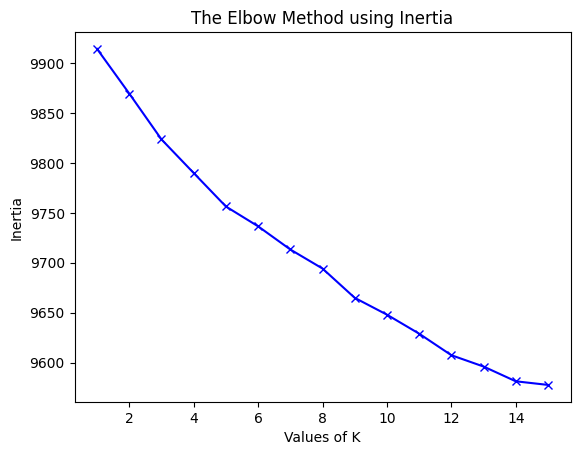

In [ ]:
elbow(15, tfidf)

## SBERT + KMeans

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=c618324afcc8ccd571c5ac6fbf1ef42e828ad0e70e0ef1048eef41729b9684e7
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
sbert_embeddings = embedder.encode(corpus)

In [ ]:
K = 10  # change number of cluster if applicable
sbert_model = KMeans(n_clusters=K, random_state=0)
sbert_model.fit(sbert_embeddings)
labels=sbert_model.labels_.tolist()  # Save cluster labels in a separate list

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print_cluster_sizes(sbert_model)

{2: 1340, 4: 895, 6: 1257, 0: 891, 3: 851, 9: 1135, 7: 942, 1: 945, 8: 695, 5: 1049}


In [ ]:
print_docs_closest_to_centroids(sbert_model, sbert_embeddings, 10)



======cluster # 0 , cluster size: 891
Cigarette smoking is increasing among Americans with drug problems
Regularoccasional teen cannabis use linked to other drug taking in early adulthood
Alcohol and tobacco are by far the biggest threat to human welfare of all addictive drugs
Marijuana smokers 5 times more likely to develop an alcohol problem
The Lancet Psychiatry Increasing number of US adults using marijuana as fewer people perceive the drug as harmful
Back of pack health warnings make little impact on teen smokers
Study finds increased menthol cigarette use among young people
Childhood exposure to secondhand smoke may increase risk of adult lung disease death
Flavored cigarette ban significantly reduced youth smoking new study finds
Children of nicotineaddicted parents more likely to become heavy smokers


======cluster # 1 , cluster size: 945
Nearly 1 in 5 with highest cardiac risk dont think they need to improve health
Targeting cardiovascular disease risk factors may be import

## BERTopic

In [ ]:
!pip install bertopic
!pip show joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 46.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039163 sha256=c462f36d757560742a3880975f06f0df8d35d643035b1a97a64c7de92de5d3cd
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-a

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(embedding_model="all-MiniLM-L12-v2", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(corpus)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2023-10-28 03:02:16,334 - BERTopic - Transformed documents to Embeddings
2023-10-28 03:03:01,106 - BERTopic - Reduced dimensionality
2023-10-28 03:03:22,711 - BERTopic - Clustered reduced embeddings


In [ ]:
# After generating topics and their probabilities, we can access the frequent topics that were generated
# -1 refers to all outliers and should typically be ignored.

freq = topic_model.get_topic_info();
num_topics = len(freq) -1
print(num_topics)
freq.head(num_topics)

201


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2586,-1_heart_health_to_of,"[heart, health, to, of, in, and, breast, the, ...",[Antibiotic use linked to greater risk of hear...
1,0,249,0_dementia_alzheimers_cognitive_memory,"[dementia, alzheimers, cognitive, memory, decl...",[Higher dementia risk linked to more use of co...
2,1,209,1_diabetes_type_insulin_glucose,"[diabetes, type, insulin, glucose, sugar, diab...",[How blood sugar levels affect risks in type 1...
3,2,186,2_birth_births_babies_childbirth,"[birth, births, babies, childbirth, labor, pre...",[Babies born just 2 or 3 weeks early at higher...
4,3,143,3_bowel_gut_inflammatory_bacteria,"[bowel, gut, inflammatory, bacteria, irritable...",[Research predicts increase in inflammatory bo...
...,...,...,...,...,...
196,195,10,195_stress_poverty_impacts_nonharmful,"[stress, poverty, impacts, nonharmful, videoco...",[Early life stress can leave lasting impacts o...
197,196,10,196_radiotherapy_radiation_ai_tool,"[radiotherapy, radiation, ai, tool, ornl, capt...",[For the first time scientists capture light f...
198,197,10,197_failure_nhs_check_deficiencies,"[failure, nhs, check, deficiencies, heart, est...",[NHS Health Check program failing at heart hea...
199,198,10,198_hepatitis_antiviral_immunosuppressives_ant...,"[hepatitis, antiviral, immunosuppressives, ant...",[Sequential treatment with entecavir and lamiv...


In [ ]:
for i in range(num_topics):
  print("\n== Representative documents in cluster #", i)
  print(topic_model.get_representative_docs(i))


== Representative documents in cluster # 0
['Higher dementia risk linked to more use of common drugs', 'Antiepileptic drugs increase risk of Alzheimers and dementia', 'Obesity linked to higher dementia risk']

== Representative documents in cluster # 1
['How blood sugar levels affect risks in type 1 diabetes', 'New oral diabetes drug shows promise in phase 3 trial for patients with type 1 diabetes', 'Smoking linked with higher risk of type 2 diabetes']

== Representative documents in cluster # 2
['Babies born just 2 or 3 weeks early at higher risk of poor health', 'Inducing labor at 39 weeks may benefit pregnant women and their babies', 'Noninvasive test could be used to predict premature birth and delivery of small babies']

== Representative documents in cluster # 3
['Research predicts increase in inflammatory bowel disease in developing world', 'Antibiotics use early in life increases risk of inflammatory bowel disease later in life', 'Biomarkers for irritable bowel syndrome']

== 

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart(top_n_topics=10)